Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Using ControlNet to control image generation

This tutorial illustrates how to use MONAI Generative Models to train a ControlNet [1]. ControlNets are hypernetworks that allow for supplying extra conditioning to ready-trained diffusion models. In this example, we will walk through training a ControlNet that allows us to specify a whole-brain mask that the sampled image must respect.



In summary, the tutorial will cover the following:
1. Loading and preprocessing a dataset (we extract the brain MRI dataset 2D slices from 3D volumes from the BraTS dataset)
2. Training a 2D diffusion model
3. Freeze the diffusion model and train a ControlNet
3. Conditional sampling with the ControlNet

[1] - Zhang et al. [Adding Conditional Control to Text-to-Image Diffusion Models](https://arxiv.org/abs/2302.05543)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [ ]:
import os
import time
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import first, set_determinism
from torch.amp import GradScaler, autocast
from tqdm import tqdm
from monai.inferers import ControlNetDiffusionInferer, DiffusionInferer
from monai.networks.nets import DiffusionModelUNet, ControlNet
from monai.networks.schedulers import DDPMScheduler

print_config()

## Setup data directory

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp8j8250od


### Set deterministic training for reproducibility

In [5]:
set_determinism(42)

## Setup the brain tumour Decathlon dataset

We now download the Decathlon tumour dataset and extract the 2D slices from the 3D volumes. The images have four MRI channels: FLAIR, T1, T1c and T2. 


### Specify transforms

We use the following transforms:
- `LoadImaged`: load the nifti image
- `EnsureChannelFirstd`: to bring the channel into the first dimension
- `Lambdad`: custom transform to select the modality (0: T1, 1: T2 etc.)
- `EnsureChannelFirstd`: do it again to create a channel (as one channel was selected previously, the channel dim is gone)
- `EnsureTyped`: we ensure that the image is indeed a tensor
- `Orientationd`: we reorient the images to make sure that they match RAS
- `Spacingd`: we bring the image resolution to 3, 3, 2
- `CenterSpatialCropd`: We select the central 64x64x44 crop
- `ScaleIntensityRangePercentilesd`: we normalise with percentiles
- `RandSpatialCropd`: we select an axial slice per volume
- `Lambdad`: we squeeze along the axial dimension
- `CopyItemsd`: we copy the image into a "mask" element
- `Lambdad`: we threshold the mask (which is the image) to turn it into a binary mask.
- `FillHolesd`: with this, we remove any potential artifact that happened during the thresholding
- `CastToTyped`: we cast to float.32

In [6]:
channel = 0
assert channel in [0, 1, 2, 3], "Choose a valid channel"

train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.Lambdad(keys=["image"], func=lambda x: x[channel, :, :, :]),
        transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        transforms.EnsureTyped(keys=["image"]),
        # transforms.Orientationd(keys=["image"], axcodes="RAS"),
        transforms.Spacingd(keys=["image"], pixdim=(3.0, 3.0, 2.0), mode="bilinear"),
        transforms.CenterSpatialCropd(keys=["image"], roi_size=(64, 64, 44)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
        transforms.RandSpatialCropd(keys=["image"], roi_size=(64, 64, 1), random_size=False),
        transforms.Lambdad(keys=["image"], func=lambda x: x.squeeze(-1)),
        transforms.CopyItemsd(keys=["image"], times=1, names=["mask"]),
        transforms.Lambdad(keys=["mask"], func=lambda x: torch.where(x > 0.1, 1, 0)),
        transforms.FillHolesd(keys=["mask"]),
        transforms.CastToTyped(keys=["mask"], dtype=np.float32),
    ]
)

We create the training and validation datasets:

In [7]:
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="training",
    cache_rate=1.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=True,
    seed=0,
    transform=train_transforms,
)
print(f"Length of training data: {len(train_ds)}")
print(f'Train image shape {train_ds[0]["image"].shape}')

val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="validation",
    cache_rate=1.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=True,
    seed=0,
    transform=train_transforms,
)
print(f"Length of val data: {len(val_ds)}")
print(f'Validation image shape {val_ds[0]["image"].shape}')

Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [01:48<00:00,  3.57it/s]


Length of training data: 387
Train image shape torch.Size([1, 64, 64])


Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:27<00:00,  3.51it/s]

Length of val data: 96
Validation image shape torch.Size([1, 64, 64])


In [8]:
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2, drop_last=True, persistent_workers=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2, drop_last=True, persistent_workers=True)

### Visualise the images and masks
We load some images and masks to make sure things make sense:

Batch shape: torch.Size([64, 1, 64, 64])


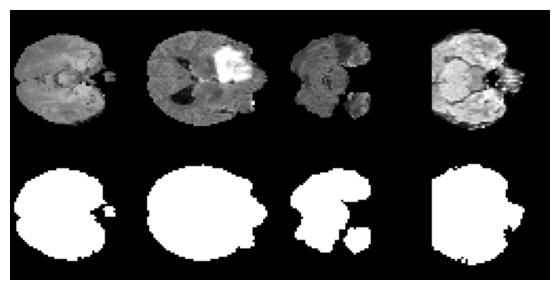

In [9]:
check_data = first(train_loader)
print(f"Batch shape: {check_data['image'].shape}")
image_visualisation = torch.cat(
    (
        torch.cat(
            [
                check_data["image"][0, 0],
                check_data["image"][1, 0],
                check_data["image"][2, 0],
                check_data["image"][3, 0],
            ],
            dim=1,
        ),
        torch.cat(
            [check_data["mask"][0, 0], check_data["mask"][1, 0], check_data["mask"][2, 0], check_data["mask"][3, 0]],
            dim=1,
        ),
    ),
    dim=0,
)
plt.figure(figsize=(6, 3))
plt.imshow(image_visualisation, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

## Train the Diffusion model
In general, a ControlNet can be trained in combination with a pre-trained, frozen diffusion model. In this case we will quickly train the diffusion model first.

### Define network, scheduler, optimizer, and inferer

In [10]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(128, 256, 256),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=256,
)
model.to(device)

scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)

### Run training


epoch:0/200: training loss 0.951951
epoch:10/200: training loss 0.437592
epoch:20/200: training loss 0.150791


validation loss: 0.052139


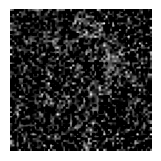

epoch:30/200: training loss 0.056416
epoch:40/200: training loss 0.032445
epoch:50/200: training loss 0.022699
validation loss: 0.032189


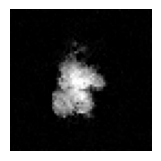

epoch:60/200: training loss 0.020905
epoch:70/200: training loss 0.025322
epoch:80/200: training loss 0.019249
validation loss: 0.014976


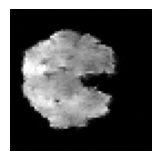

epoch:90/200: training loss 0.021246
epoch:100/200: training loss 0.013711
epoch:110/200: training loss 0.017492
validation loss: 0.019058


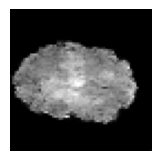

epoch:120/200: training loss 0.020393
epoch:130/200: training loss 0.020519
epoch:140/200: training loss 0.015537
validation loss: 0.026484


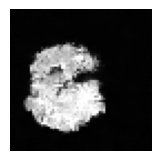

epoch:150/200: training loss 0.017830
epoch:160/200: training loss 0.017770
epoch:170/200: training loss 0.020470
validation loss: 0.017254


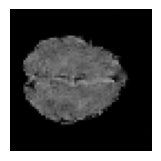

epoch:180/200: training loss 0.018951
epoch:190/200: training loss 0.021716
train completed, total time: 466.27585434913635.


In [12]:
max_epochs = 200
val_interval = 30
epoch_loss_list = []
val_epoch_loss_list = []
print_every = 10

scaler = GradScaler("cuda")
total_start = time.time()
for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast("cuda", enabled=False):
            # Generate random noise
            noise = torch.randn_like(images).to(device)

            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()

            # Get model prediction
            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

    if epoch % print_every == 0:
        msg = f"epoch:{epoch:d}/{max_epochs:d}: training loss {np.mean(epoch_loss / len(train_loader)):4f}"
        print(msg)

    epoch_loss_list.append(epoch_loss / len(train_loader))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        for batch in val_loader:
            images = batch["image"].to(device)
            with torch.no_grad():
                with autocast("cuda", enabled=False):
                    noise = torch.randn_like(images).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                    ).long()
                    noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()
        val_epoch_loss_list.append(val_epoch_loss / len(val_loader))
        msg = f"validation loss: {val_epoch_loss_list[-1]:4f}"
        print(msg)

        # Sampling image during training
        noise = torch.randn((1, 1, 64, 64))
        noise = noise.to(device)
        scheduler.set_timesteps(num_inference_steps=1000)
        with autocast("cuda", enabled=True):
            image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler, verbose=False)

        plt.figure(figsize=(2, 2))
        plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

## Train the ControlNet

### Set up models

In [13]:
# Create control net
controlnet = ControlNet(
    spatial_dims=2,
    in_channels=1,
    channels=(128, 256, 256),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=256,
    conditioning_embedding_num_channels=(16,),
)
# Copy weights from the DM to the controlnet
controlnet.load_state_dict(model.state_dict(), strict=False)
controlnet = controlnet.to(device)
# Now, we freeze the parameters of the diffusion model.
for p in model.parameters():
    p.requires_grad = False
optimizer = torch.optim.Adam(params=controlnet.parameters(), lr=2.5e-5)
controlnet_inferer = ControlNetDiffusionInferer(scheduler)

### Run ControlNet training

epoch:0/150: training loss 0.015892
epoch:10/150: training loss 0.019003
epoch:20/150: training loss 0.023880


validation loss: 0.012547


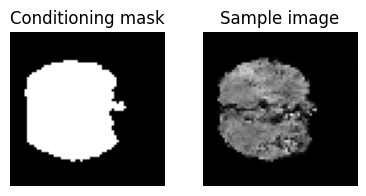

epoch:30/150: training loss 0.016548
epoch:40/150: training loss 0.014306
validation loss: 0.014935


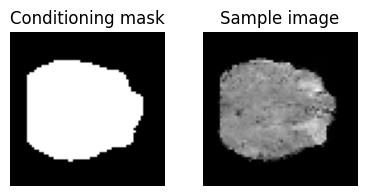

epoch:50/150: training loss 0.016530
epoch:60/150: training loss 0.019910
epoch:70/150: training loss 0.015304
validation loss: 0.024789


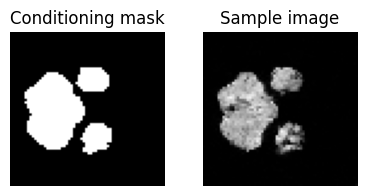

epoch:80/150: training loss 0.019710
epoch:90/150: training loss 0.015484
validation loss: 0.017555


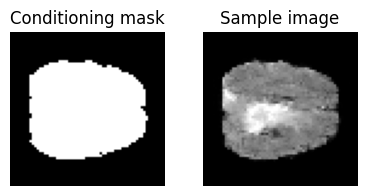

epoch:100/150: training loss 0.014432
epoch:110/150: training loss 0.012640
epoch:120/150: training loss 0.012768
validation loss: 0.011241


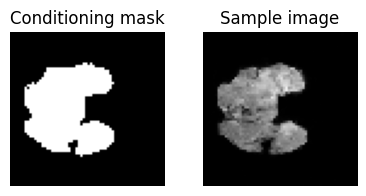

epoch:130/150: training loss 0.011723
epoch:140/150: training loss 0.022256
validation loss: 0.012630


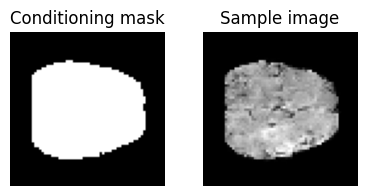

train completed, total time: 464.29540824890137.


In [14]:
max_epochs = 150
val_interval = 25
epoch_loss_list = []
val_epoch_loss_list = []

scaler = GradScaler("cuda")
total_start = time.time()
for epoch in range(max_epochs):
    controlnet.train()
    epoch_loss = 0
    for batch in train_loader:
        images = batch["image"].to(device)
        masks = batch["mask"].to(device)

        optimizer.zero_grad(set_to_none=True)

        with autocast("cuda", enabled=True):
            # Generate random noise
            noise = torch.randn_like(images).to(device)

            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()

            noise_pred = controlnet_inferer(
                inputs=images,
                diffusion_model=model,
                controlnet=controlnet,
                noise=noise,
                timesteps=timesteps,
                cn_cond=masks,
            )

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

    if epoch % print_every == 0:
        msg = f"epoch:{epoch:d}/{max_epochs:d}: training loss {np.mean(epoch_loss / len(train_loader)):4f}"
        print(msg)

    epoch_loss_list.append(epoch_loss / len(train_loader))

    if (epoch + 1) % val_interval == 0:
        controlnet.eval()
        val_epoch_loss = 0
        for batch in val_loader:
            images = batch["image"].to(device)
            masks = batch["mask"].to(device)

            with torch.no_grad():
                with autocast("cuda", enabled=True):
                    noise = torch.randn_like(images).to(device)
                    timesteps = torch.randint(
                        0, controlnet_inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                    ).long()

                    noise_pred = controlnet_inferer(
                        inputs=images,
                        diffusion_model=model,
                        controlnet=controlnet,
                        noise=noise,
                        timesteps=timesteps,
                        cn_cond=masks,
                    )
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())
            val_epoch_loss += val_loss.item()

        val_epoch_loss_list.append(val_epoch_loss / len(val_loader))
        msg = f"validation loss: {val_epoch_loss_list[-1]:4f}"
        print(msg)

        # Sampling image during training with controlnet conditioning

        with torch.no_grad():
            with autocast("cuda", enabled=True):
                noise = torch.randn((1, 1, 64, 64)).to(device)
                sample = controlnet_inferer.sample(
                    input_noise=noise,
                    diffusion_model=model,
                    controlnet=controlnet,
                    cn_cond=masks[0, None, ...],
                    scheduler=scheduler,
                    verbose=False,
                )
        plt.subplots(1, 2, figsize=(4, 2))
        plt.subplot(1, 2, 1)
        plt.imshow(masks[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.axis("off")
        plt.title("Conditioning mask")
        plt.subplot(1, 2, 2)
        plt.imshow(sample[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.axis("off")
        plt.title("Sample image")
        plt.tight_layout()
        plt.axis("off")
        plt.show()

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

## Sample with ControlNet conditioning
First we'll provide a few different masks from the validation data as conditioning. The samples should respect the shape of the conditioning mask, but don't need to have the same content as the corresponding validation image.

sampling...: 100%|████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 28.38it/s]


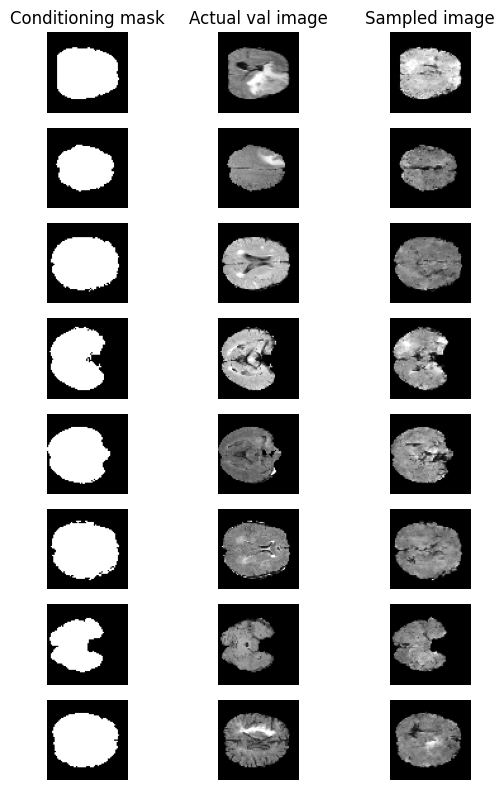

In [15]:
progress_bar_sampling = tqdm(scheduler.timesteps, total=len(scheduler.timesteps), ncols=110, position=0, leave=True)
progress_bar_sampling.set_description("sampling...")
num_samples = 8
sample = torch.randn((num_samples, 1, 64, 64)).to(device)

val_batch = first(val_loader)
val_images = val_batch["image"].to(device)
val_masks = val_batch["mask"].to(device)
for t in progress_bar_sampling:
    with torch.no_grad():
        with autocast("cuda", enabled=True):
            down_block_res_samples, mid_block_res_sample = controlnet(
                x=sample, timesteps=torch.Tensor((t,)).to(device).long(), controlnet_cond=val_masks[:num_samples, ...]
            )
            noise_pred = model(
                sample,
                timesteps=torch.Tensor((t,)).to(device),
                down_block_additional_residuals=down_block_res_samples,
                mid_block_additional_residual=mid_block_res_sample,
            )
            sample, _ = scheduler.step(model_output=noise_pred, timestep=t, sample=sample)

plt.subplots(num_samples, 3, figsize=(6, 8))
for k in range(num_samples):
    plt.subplot(num_samples, 3, k * 3 + 1)
    plt.imshow(val_masks[k, 0, ...].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    if k == 0:
        plt.title("Conditioning mask")
    plt.subplot(num_samples, 3, k * 3 + 2)
    plt.imshow(val_images[k, 0, ...].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    if k == 0:
        plt.title("Actual val image")
    plt.subplot(num_samples, 3, k * 3 + 3)
    plt.imshow(sample[k, 0, ...].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    if k == 0:
        plt.title("Sampled image")
plt.tight_layout()
plt.show()

What happens if we invent some masks? Let's try a circle, and a square

sampling...: 100%|████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 66.57it/s]


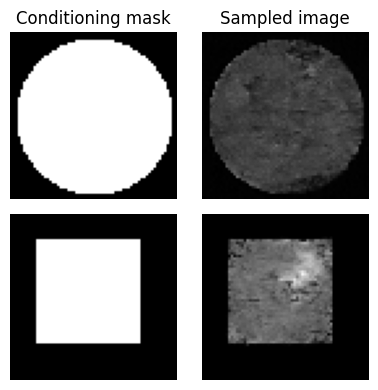

In [16]:
xx, yy = np.mgrid[:64, :64]
circle = ((xx - 32) ** 2 + (yy - 32) ** 2) < 30**2

square = np.zeros((64, 64))
square[10:50, 10:50] = 1

mask = np.concatenate((circle[None, None, ...], square[None, None, ...]), axis=0)
mask = torch.from_numpy(mask.astype(np.float32)).to(device)


progress_bar_sampling = tqdm(scheduler.timesteps, total=len(scheduler.timesteps), ncols=110, position=0, leave=True)
progress_bar_sampling.set_description("sampling...")
num_samples = 2
sample = torch.randn((num_samples, 1, 64, 64)).to(device)

for t in progress_bar_sampling:
    with torch.no_grad():
        with autocast("cuda", enabled=True):
            down_block_res_samples, mid_block_res_sample = controlnet(
                x=sample, timesteps=torch.Tensor((t,)).to(device).long(), controlnet_cond=mask
            )
            noise_pred = model(
                sample,
                timesteps=torch.Tensor((t,)).to(device),
                down_block_additional_residuals=down_block_res_samples,
                mid_block_additional_residual=mid_block_res_sample,
            )
            sample, _ = scheduler.step(model_output=noise_pred, timestep=t, sample=sample)

plt.subplots(num_samples, 2, figsize=(4, 4))
for k in range(num_samples):
    plt.subplot(num_samples, 2, k * 2 + 1)
    plt.imshow(mask[k, 0, ...].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    if k == 0:
        plt.title("Conditioning mask")
    plt.subplot(num_samples, 2, k * 2 + 2)
    plt.imshow(sample[k, 0, ...].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    if k == 0:
        plt.title("Sampled image")
plt.tight_layout()
plt.show()